# Practica Paisajes

In [1]:
import cv2
import numpy as np
import math
import random
from google.colab.patches import cv2_imshow

In [2]:
SCREEN_WIDTH = 700
SCREEN_HEIGHT = 700
WINDOW_NAME = "Un Paisaje Fractal Sin Ti"

# --- Colores Estilo "Un Verano Sin Ti" (BGR) ---
SKY_PINK_TOP_BB = (210, 210, 255)
SKY_ORANGE_BOTTOM_BB = (180, 200, 250)

SUN_YELLOW_BB = (60, 230, 255)
SUN_ORANGE_RAYS_BB = (30, 170, 250)
BIRD_SILHOUETTE_BB = (80, 80, 80)

DOLPHIN_BLUE_BB = (230, 190, 130)
DOLPHIN_HIGHLIGHT_BB = (250, 220, 180)

OCEAN_BLUE_BB = (220, 170, 100)
OCEAN_LIGHTER_BB = (230, 190, 140)

SAND_ORANGE_BB = (100, 190, 240)
SAND_YELLOW_BB = (120, 220, 255)

PALM_TRUNK_BROWN_BB = (40, 90, 140)
PALM_LEAF_GREEN_BB = (80, 150, 70)

FLOWER_PINK_BB = (180, 150, 220)
FLOWER_CENTER_YELLOW_BB = (100, 220, 240)
FLOWER_STEM_GREEN_BB = PALM_LEAF_GREEN_BB # Reusar color

HEART_RED_BB = (50, 50, 220)
HEART_LIMB_BLACK_BB = (30, 30, 30)
HEART_GLOVE_WHITE_BB = (230, 230, 230)
HEART_SHOE_BLACK_BB = (20, 20, 20)
HEART_EYE_WHITE_BB = (240, 240, 240)
HEART_PUPIL_BLACK_BB = (10,10,10)
HEART_MOUTH_BLACK_BB = (25,25,25)

# Color para lienzos de piezas individuales
PIECE_CANVAS_BG = (20,20,20) # Gris oscuro para

CLOUD_WHITE_BB = (245, 245, 245)
CLOUD_SHADOW_BB = (210, 210, 220) # Un gris muy claro o rosa/naranja muy pálido

WAVE_CREST_WHITE_BB = (250, 250, 250)

In [3]:
def draw_fractal_recursive(img, x, y, length, angle_deg,
                           branch_rules, color_func,
                           current_depth, max_depth,
                           thickness_func, min_length=1.0):
    if current_depth > max_depth or length < min_length:
        return
    # Modificación: color_func ahora puede no necesitar max_depth si no lo usa
    try:
        color = color_func(current_depth, max_depth)
    except TypeError: # Si color_func solo toma current_depth
        color = color_func(current_depth)

    thickness = thickness_func(current_depth)
    angle_rad = math.radians(angle_deg)
    x_end = x + length * math.cos(angle_rad)
    y_end = y - length * math.sin(angle_rad) # Y invertida para pantalla

    # Asegurar que las coordenadas sean enteras y estén dentro de los límites
    h, w = img.shape[:2]
    pt1 = (np.clip(int(x), 0, w-1), np.clip(int(y), 0, h-1))
    pt2 = (np.clip(int(x_end), 0, w-1), np.clip(int(y_end), 0, h-1))

    cv2.line(img, pt1, pt2, color, thickness)

    for angle_offset, length_scale in branch_rules:
        new_angle = angle_deg + angle_offset
        new_length = length * length_scale
        draw_fractal_recursive(img, x_end, y_end, new_length, new_angle,
                               branch_rules, color_func,
                               current_depth + 1, max_depth,
                               thickness_func, min_length)

In [4]:
def draw_bb_sun(img, cx, cy, core_radius, num_main_rays, ray_base_len, ray_depth, draw_core=True, draw_birds=True):
    if draw_core:
        cv2.circle(img, (cx, cy), core_radius, SUN_YELLOW_BB, -1)
        cv2.circle(img, (cx, cy), core_radius, SUN_ORANGE_RAYS_BB, 2)

    ray_branch_rules = [(-5, 0.85), (0, 0.9), (5, 0.85)]
    def ray_color_func(depth, max_d): return SUN_ORANGE_RAYS_BB
    def ray_thickness_func(depth): return max(1, int(core_radius/20) - depth) # Ajustado para lienzos pequeños

    angle_step = 360 / (num_main_rays * 2)
    for i in range(num_main_rays * 2):
        start_angle = i * angle_step
        current_ray_len = ray_base_len * (0.6 if i % 2 == 0 else 1.0)
        current_ray_len *= random.uniform(0.9,1.1)
        draw_fractal_recursive(img, cx, cy, current_ray_len, start_angle,
                               ray_branch_rules, ray_color_func, 0, ray_depth,
                               ray_thickness_func, min_length=1) # min_length más pequeño para piezas
    if draw_birds:
        for _ in range(3):
            gx_off = random.uniform(-core_radius*0.5, core_radius*0.5)
            gy_off = random.uniform(core_radius*0.1, core_radius*0.3)
            pt1 = (cx + int(gx_off) - 5, cy + int(gy_off))
            pt2 = (cx + int(gx_off), cy + int(gy_off) -3)
            pt3 = (cx + int(gx_off) + 5, cy + int(gy_off))
            cv2.line(img, pt1,pt2, BIRD_SILHOUETTE_BB,1)
            cv2.line(img, pt2,pt3, BIRD_SILHOUETTE_BB,1)

def draw_abstract_dolphin_shape(img, x_start, y_start, base_len, main_angle, depth):
    dolphin_rules = [(random.uniform(-10, 10), random.uniform(0.8, 0.9)), (random.uniform(60, 100), random.uniform(0.3, 0.4))]
    if random.random() < 0.5: dolphin_rules[1] = (random.uniform(-20,20), random.uniform(0.4,0.6))
    def dol_color_func(d, max_d): return DOLPHIN_BLUE_BB if d < depth * 0.7 else DOLPHIN_HIGHLIGHT_BB
    def dol_thick_func(d): return max(1, int(base_len / 10) - d) # Ajustado
    draw_fractal_recursive(img, x_start, y_start, base_len, main_angle, dolphin_rules, dol_color_func, 0, depth, dol_thick_func, min_length=2)


def draw_palm_fronds_only(img, x_origin, y_origin, leaf_base_len, leaf_depth, num_fronds=5, angle_spread=160, angle_start_offset=0):
    angle_start = 90 - angle_spread / 2 + angle_start_offset
    frond_rules = [(-15, 0.75), (0, 0.8), (15, 0.75)]
    def frond_color(d,max_d): return PALM_LEAF_GREEN_BB
    def frond_thick(d): return max(1, 3-d)
    for i in range(num_fronds):
        frond_angle = angle_start + (i * angle_spread / (num_fronds -1 if num_fronds > 1 else 1))
        frond_angle += random.uniform(-10,10)
        current_leaf_len = leaf_base_len * random.uniform(0.8, 1.2)
        draw_fractal_recursive(img, x_origin, y_origin, current_leaf_len, frond_angle,
                               frond_rules, frond_color, 0, leaf_depth,
                               frond_thick, min_length=1)

def draw_palm_tree_bb(img, x_root, y_root, trunk_h, leaf_base_len, leaf_depth):
    trunk_top_x = x_root # Simplificado para tronco recto si no hay viento
    trunk_top_y = y_root - trunk_h
    cv2.line(img, (x_root, y_root), (trunk_top_x, trunk_top_y), PALM_TRUNK_BROWN_BB, max(2, int(trunk_h/10)))
    draw_palm_fronds_only(img, trunk_top_x, trunk_top_y, leaf_base_len, leaf_depth, num_fronds=random.randint(5,7))

def draw_flower_petals_only(img, cx, cy, petal_len, petal_depth, num_petals=5):
    petal_rules = [(0, 0.6)]
    def petal_color(d,max_d): return FLOWER_PINK_BB
    def petal_thick(d): return 2
    for i in range(num_petals):
        angle = (360 / num_petals) * i + random.uniform(-10,10)
        draw_fractal_recursive(img, cx, cy, petal_len, angle,
                               petal_rules, petal_color, 0, petal_depth,
                               petal_thick, min_length=1)

def draw_flower_bb(img, cx, cy, stem_h, petal_len, petal_depth):
    stem_top_x = cx
    stem_top_y = cy - stem_h
    cv2.line(img, (cx, cy), (stem_top_x, stem_top_y), FLOWER_STEM_GREEN_BB, 2)
    draw_flower_petals_only(img, stem_top_x, stem_top_y, petal_len, petal_depth, num_petals=random.randint(5,6))
    cv2.circle(img, (stem_top_x, stem_top_y), int(petal_len/3), FLOWER_CENTER_YELLOW_BB, -1)

# Tu función draw_heart_figure_bb (la mantengo como la tenías, ya que es principalmente no fractal para el cuerpo)
def draw_heart_figure_bb(img, cx, bottom_y, heart_w, heart_h):
    ellipse_center_y = bottom_y - heart_h + heart_h // 4
    ellipse_radius_x = heart_w // 4
    ellipse_radius_y = heart_h // 4
    cv2.ellipse(img, (cx - ellipse_radius_x, ellipse_center_y), (ellipse_radius_x, ellipse_radius_y), 0, 180, 360, HEART_RED_BB, -1)
    cv2.ellipse(img, (cx + ellipse_radius_x, ellipse_center_y), (ellipse_radius_x, ellipse_radius_y), 0, 180, 360, HEART_RED_BB, -1)
    points = np.array([[cx - heart_w // 2, bottom_y - heart_h * 0.6],[cx + heart_w // 2, bottom_y - heart_h * 0.6],[cx, bottom_y]], np.int32)
    cv2.fillPoly(img, [points], HEART_RED_BB)
    cv2.rectangle(img,(cx - heart_w//2, bottom_y - int(heart_h*0.75)),(cx + heart_w//2, bottom_y - int(heart_h*0.35)),HEART_RED_BB, -1)
    eye_y = bottom_y - int(heart_h * 0.65); eye_r = heart_w // 7
    cv2.circle(img, (cx - heart_w // 27, eye_y), eye_r, HEART_EYE_WHITE_BB, -1)
    cv2.ellipse(img, (cx - heart_w // 27, eye_y + eye_r//3), (eye_r//3, eye_r//2), 0, 0, 360, HEART_PUPIL_BLACK_BB, -1)

    mouth_y = bottom_y - int(heart_h * 0.25) # Misma posición Y
    mouth_w = heart_w // 3
    mouth_h_arc = heart_h // 10

    cv2.ellipse(img, (cx, mouth_y - mouth_h_arc // 2), (mouth_w // 2, mouth_h_arc), 0, 180, 360, HEART_MOUTH_BLACK_BB, max(1,heart_w//30))

    arm_len = heart_h * 0.4; arm_thickness = max(1, heart_w // 25)
    def arm_color(d,max_d): return HEART_LIMB_BLACK_BB
    def arm_thick(d): return arm_thickness
    # Brazo izquierdo (Fractal de 1 segmento)
    draw_fractal_recursive(img, cx - heart_w//2 * 0.8, bottom_y - heart_h * 0.6, arm_len, 220, [], arm_color, 0, 0, arm_thick)
    hand_x_l = cx - heart_w//2 * 0.8 + arm_len * math.cos(math.radians(220)); hand_y_l = bottom_y - heart_h * 0.6 - arm_len * math.sin(math.radians(220))
    cv2.circle(img, (int(hand_x_l), int(hand_y_l)), arm_thickness * 2, HEART_GLOVE_WHITE_BB, -1); cv2.circle(img, (int(hand_x_l), int(hand_y_l)), arm_thickness * 2, HEART_LIMB_BLACK_BB, 1)
    # Brazo derecho (Fractal de 1 segmento)
    draw_fractal_recursive(img, cx + heart_w//2 * 0.8, bottom_y - heart_h * 0.6, arm_len, -40, [], arm_color, 0, 0, arm_thick)
    hand_x_r = cx + heart_w//2 * 0.8 + arm_len * math.cos(math.radians(-40)); hand_y_r = bottom_y - heart_h * 0.6 - arm_len * math.sin(math.radians(-40))
    cv2.circle(img, (int(hand_x_r), int(hand_y_r)), arm_thickness * 2, HEART_GLOVE_WHITE_BB, -1); cv2.circle(img, (int(hand_x_r), int(hand_y_r)), arm_thickness * 2, HEART_LIMB_BLACK_BB, 1)
    leg_h = heart_h * 0.3; leg_y_start = bottom_y - leg_h * 0.3; shoe_h = heart_h * 0.25; shoe_w = heart_w * 0.2
    def leg_color(d,max_d): return HEART_SHOE_BLACK_BB
    def leg_thick(d): return max(3, heart_w // 10)
     # Pierna izquierda (Fractal de 1 segmento)
    draw_fractal_recursive(img, cx - heart_w * 0.15, leg_y_start, leg_h, 270, [], leg_color, 0, 0, leg_thick)
    cv2.ellipse(img, (int(cx - heart_w * 0.15), int(leg_y_start + leg_h + shoe_h*0.3)), (int(shoe_w*0.7), int(shoe_h*0.6)), 0,0,360, HEART_SHOE_BLACK_BB, -1)
     # Pierna derecha (Fractal de 1 segmento)
    draw_fractal_recursive(img, cx + heart_w * 0.15, leg_y_start, leg_h, 270, [], leg_color, 0, 0, leg_thick)
    cv2.ellipse(img, (int(cx + heart_w * 0.15), int(leg_y_start + leg_h + shoe_h*0.3)), (int(shoe_w*0.7), int(shoe_h*0.6)), 0,0,360, HEART_SHOE_BLACK_BB, -1)


def draw_cloud_bb(img, x_start, y_start, initial_length, initial_angle_deg, max_depth, min_length_cloud=2):
    """
    Dibuja una nube fractal basada en la lógica de la función C proporcionada.
    """
    # Colores para la nube
    def cloud_color_func(depth, max_d):
        # Más blanco en las capas exteriores/menor profundidad
        if depth < max_d * 0.6:
            return CLOUD_WHITE_BB
        else:
            return CLOUD_SHADOW_BB # Sombra sutil en el interior

    def cloud_thickness_func(depth):
        return max(1, int(initial_length / 8) - depth) # Ajustar según el tamaño inicial

    # Función recursiva interna específica para la nube para manejar la ramificación mixta
    def _draw_cloud_recursive_internal(img_internal, x0, y0, length, angle_deg, current_depth):
        if current_depth > max_depth or length < min_length_cloud:
            return

        color = cloud_color_func(current_depth, max_depth)
        thickness = cloud_thickness_func(current_depth)

        angle_rad = math.radians(angle_deg)
        # En la función C, an=0 era a la izquierda, an=90 arriba.
        # Adaptamos: 0° a la derecha, 90° arriba.
        # La función C hacía x1 = x0 - L*cos, y1 = y0 - L*sin
        # Para que sea igual, nuestro x_end debería ser x0 + L*cos(angle+180) o x0 - L*cos(angle)
        # y nuestro y_end debería ser y0 - L*sin(angle+180) o y0 + L*sin(angle)
        # Pero es más simple usar nuestra convención y ajustar los ángulos de las reglas.
        # Ángulos originales en C: +30, +50, +100 (relativos a la dirección 'an' que ya estaba invertida)
        # Si 'an' 0 era izquierda, 'an'+30 es más hacia arriba-izquierda.
        # Si nuestro 0 es derecha, un ángulo de ~150° (180-30) sería izquierda-arriba.

        x_end = x0 + length * math.cos(angle_rad)
        y_end = y0 - length * math.sin(angle_rad) # Y invertida para pantalla

        h_img, w_img = img_internal.shape[:2]
        pt1_c = (np.clip(int(x0), 0, w_img-1), np.clip(int(y0), 0, h_img-1))
        pt2_c = (np.clip(int(x_end), 0, w_img-1), np.clip(int(y_end), 0, h_img-1))
        cv2.line(img_internal, pt1_c, pt2_c, color, thickness)

        # Reglas de la función C:
        # 1. nube(x0,y0,l/1.25,an+30,ind-1);
        _draw_cloud_recursive_internal(img_internal, x0, y0, # Desde el origen de esta rama
                                       length / 1.25, angle_deg + 30, current_depth + 1)
        # 2. nube(x1,y1,l/1.3,an+50,ind-1);
        _draw_cloud_recursive_internal(img_internal, x_end, y_end, # Desde el final de esta rama
                                       length / 1.3, angle_deg + 50, current_depth + 1)
        # 3. nube(x1,y1,l/1.4,an+100,ind-1);
        _draw_cloud_recursive_internal(img_internal, x_end, y_end, # Desde el final de esta rama
                                       length / 1.4, angle_deg + 100, current_depth + 1)

    # Iniciar la recursión interna de la nube
    _draw_cloud_recursive_internal(img, x_start, y_start, initial_length, initial_angle_deg, 0)


def draw_ocean_waves_bb(img, y_horizon, y_shore, wave_height_max, num_wave_lines, wave_segment_len, wave_depth):
    """
    Dibuja múltiples líneas de olas fractales entre el horizonte y la orilla.
    """
    ocean_height = y_shore - y_horizon
    if ocean_height <= 0: return

    def wave_color_func(depth, max_d):
        if depth > max_d * 0.7: # Cresta de la ola
            return WAVE_CREST_WHITE_BB
        elif depth > max_d * 0.4:
            return OCEAN_LIGHTER_BB
        return OCEAN_BLUE_BB

    def wave_thickness_func(depth):
        return max(1, 2 - depth) # Olas finas

    # Reglas para olas: bastante planas, pequeñas desviaciones
    # (angle_offset, length_scale_factor)
    wave_branch_rules = [
        (random.uniform(-10, -2), random.uniform(0.7, 0.9)), # Ligera curva hacia arriba
        (random.uniform(2, 10),   random.uniform(0.7, 0.9))  # Ligera curva hacia abajo
    ]
    # A veces una ola más simple
    if random.random() < 0.3:
        wave_branch_rules = [(random.uniform(-5, 5), random.uniform(0.8, 0.95))]


    for i in range(num_wave_lines):
        # Las olas más cercanas a la orilla (y_shore) son más grandes y detalladas
        # Las olas más cercanas al horizonte (y_horizon) son más pequeñas y menos detalladas
        progression = (i / (num_wave_lines -1 if num_wave_lines > 1 else 1)) # 0 (horizonte) a 1 (orilla)

        current_y = y_horizon + int(ocean_height * progression * progression) # Progresión no lineal, más olas cerca de la orilla
        current_wave_height = wave_height_max * (0.3 + 0.7 * progression) # Más altas cerca de la orilla
        current_depth = int(wave_depth * (0.5 + 0.5 * progression))
        current_segment_len = wave_segment_len * (0.6 + 0.4 * progression)

        num_segments = SCREEN_WIDTH // int(current_segment_len * 0.7) # Cuántos fractales de ola por línea

        for j in range(num_segments):
            x_start = j * int(current_segment_len * 0.7) - random.randint(0, int(current_segment_len *0.3))
            # Ángulo inicial casi horizontal, con ligera variación
            initial_angle = 180 + random.uniform(-5, 5) # 180 para ir de izquierda a derecha (o 0)

            # La "longitud" inicial es la altura de la ola, el fractal la "romperá"
            draw_fractal_recursive(img, x_start, current_y,
                                   current_wave_height * random.uniform(0.5, 1.2), # Variación en altura
                                   initial_angle,
                                   wave_branch_rules, wave_color_func,
                                   0, max(1, current_depth), # Asegurar al menos 1 de profundidad
                                   wave_thickness_func, min_length=1)


[PIEZA] Rayos del Sol:


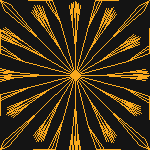

In [5]:
piece_canvas_size = 150 # Tamaño del lienzo para cada pieza

# --- Rayos del Sol (Fractal) ---
print("\n[PIEZA] Rayos del Sol:")
sun_rays_canvas = np.full((piece_canvas_size, piece_canvas_size, 3), PIECE_CANVAS_BG, dtype=np.uint8)
draw_bb_sun(sun_rays_canvas, piece_canvas_size//2, piece_canvas_size//2,
            core_radius=piece_canvas_size//10, num_main_rays=12, ray_base_len=piece_canvas_size//3, ray_depth=2,
            draw_core=False, draw_birds=False) # Solo los rayos
cv2_imshow(sun_rays_canvas)


[PIEZA] Delfín Abstracto


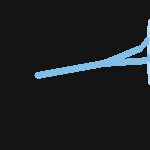

In [6]:
print("\n[PIEZA] Delfín Abstracto")
dolphin_canvas_2 = np.full((piece_canvas_size, piece_canvas_size, 3), PIECE_CANVAS_BG, dtype=np.uint8)
draw_abstract_dolphin_shape(dolphin_canvas_2, piece_canvas_size//4, piece_canvas_size//2,
                            base_len=piece_canvas_size//2.2, main_angle=10, depth=4)
cv2_imshow(dolphin_canvas_2)


[PIEZA] Hojas de Palmera (Frondas):


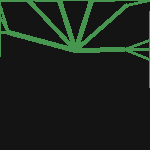

In [7]:
print("\n[PIEZA] Hojas de Palmera (Frondas):")
palm_fronds_canvas = np.full((piece_canvas_size, piece_canvas_size, 3), PIECE_CANVAS_BG, dtype=np.uint8)
draw_palm_fronds_only(palm_fronds_canvas, piece_canvas_size//2, piece_canvas_size//3, # Origen arriba-centro
                      leaf_base_len=piece_canvas_size//2.5, leaf_depth=3, num_fronds=6)
cv2_imshow(palm_fronds_canvas)


[PIEZA] Pétalos de Flor:


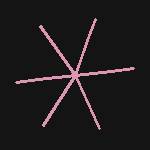

In [8]:
print("\n[PIEZA] Pétalos de Flor:")
flower_petals_canvas = np.full((piece_canvas_size, piece_canvas_size, 3), PIECE_CANVAS_BG, dtype=np.uint8)
draw_flower_petals_only(flower_petals_canvas, piece_canvas_size//2, piece_canvas_size//2,
                        petal_len=piece_canvas_size//4, petal_depth=1, num_petals=6)
cv2_imshow(flower_petals_canvas)


[PIEZA] Nube Fractal:


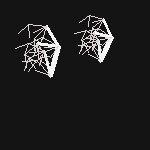

In [9]:
print("\n[PIEZA] Nube Fractal:")
cloud_canvas = np.full((piece_canvas_size, piece_canvas_size, 3), PIECE_CANVAS_BG, dtype=np.uint8)
# Para la nube, la función draw_cloud_bb es específica, así que la usamos directamente.
# Los ángulos iniciales pueden necesitar ajuste para una buena forma en el lienzo pequeño.
draw_cloud_bb(cloud_canvas, piece_canvas_size//3, piece_canvas_size//2,
              initial_length=piece_canvas_size//5, initial_angle_deg=random.uniform(70,110), max_depth=3, min_length_cloud=2)
draw_cloud_bb(cloud_canvas, piece_canvas_size*2//3, piece_canvas_size//2.5, # Otra parte de la nube
              initial_length=piece_canvas_size//6, initial_angle_deg=random.uniform(60,100), max_depth=3, min_length_cloud=2)
cv2_imshow(cloud_canvas)


[PIEZA] Segmento de Ola Fractal:


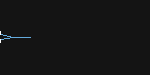

In [10]:
print("\n[PIEZA] Segmento de Ola Fractal:")
wave_canvas = np.full((piece_canvas_size // 2, piece_canvas_size, 3), PIECE_CANVAS_BG, dtype=np.uint8) # Más ancho que alto
temp_wave_rules = [(-8, 0.8), (8, 0.8)]
def temp_wave_color(d, max_d): return OCEAN_BLUE_BB if d < 2 else WAVE_CREST_WHITE_BB
def temp_wave_thick(d): return 1
draw_fractal_recursive(wave_canvas, piece_canvas_size // 5, piece_canvas_size // 4,
                       length=piece_canvas_size // 8, angle_deg=180, # Altura de ola, dirección horizontal
                       branch_rules=temp_wave_rules, color_func=temp_wave_color,
                       current_depth=0, max_depth=2, thickness_func=temp_wave_thick, min_length=1)
cv2_imshow(wave_canvas)

In [11]:
def create_bad_bunny_scape():
    img = np.zeros((SCREEN_HEIGHT, SCREEN_WIDTH, 3), dtype=np.uint8)
    sky_line_y = SCREEN_HEIGHT * 2 // 5
    for y_sky in range(sky_line_y):
        alpha = y_sky / sky_line_y
        color = (int(SKY_PINK_TOP_BB[0]*(1-alpha)+SKY_ORANGE_BOTTOM_BB[0]*alpha), int(SKY_PINK_TOP_BB[1]*(1-alpha)+SKY_ORANGE_BOTTOM_BB[1]*alpha), int(SKY_PINK_TOP_BB[2]*(1-alpha)+SKY_ORANGE_BOTTOM_BB[2]*alpha))
        cv2.line(img, (0, y_sky), (SCREEN_WIDTH, y_sky), color, 1)

    num_clouds = 7
    for _ in range(num_clouds):
        cloud_x = random.randint(SCREEN_WIDTH // 10, SCREEN_WIDTH * 9 // 10)
        cloud_y = random.randint(SCREEN_HEIGHT // 10, sky_line_y - SCREEN_HEIGHT // 10)
        cloud_len = random.randint(SCREEN_WIDTH // 15, SCREEN_WIDTH // 10)
        cloud_angle = random.uniform(45, 135) # Hacia arriba y a los lados
        cloud_depth = random.randint(3, 4)
        draw_cloud_bb(img, cloud_x, cloud_y, cloud_len, cloud_angle, cloud_depth, min_length_cloud=3)

    sun_cx = SCREEN_WIDTH*3//4; sun_cy = SCREEN_HEIGHT//5
    draw_bb_sun(img, sun_cx, sun_cy, SCREEN_WIDTH//20, 18, SCREEN_WIDTH//15, 2)

    ocean_line_y = SCREEN_HEIGHT*3//5
    for y_ocean in range(sky_line_y, ocean_line_y):
        alpha = (y_ocean - sky_line_y) / (ocean_line_y - sky_line_y)
        color = (int(OCEAN_BLUE_BB[0]*(1-alpha)+OCEAN_LIGHTER_BB[0]*alpha), int(OCEAN_BLUE_BB[1]*(1-alpha)+OCEAN_LIGHTER_BB[1]*alpha), int(OCEAN_BLUE_BB[2]*(1-alpha)+OCEAN_LIGHTER_BB[2]*alpha))
        cv2.line(img, (0,y_ocean), (SCREEN_WIDTH, y_ocean), color,1)

    draw_ocean_waves_bb(img, y_horizon=sky_line_y + 10, y_shore=ocean_line_y - 5, # Un poco dentro de los límites del mar
                        wave_height_max=SCREEN_HEIGHT // 60, # Altura máxima de una cresta
                        num_wave_lines=random.randint(6,10),  # Cuántas "filas" de olas
                        wave_segment_len=SCREEN_WIDTH // 10, # Longitud base de un fractal de ola
                        wave_depth=2) # Profundidad fractal de cada ola

    draw_abstract_dolphin_shape(img, SCREEN_WIDTH//4, SCREEN_HEIGHT//6, SCREEN_WIDTH//10, 30, 4)
    draw_abstract_dolphin_shape(img, SCREEN_WIDTH//3, SCREEN_HEIGHT//7, SCREEN_WIDTH//9, 10, 4)
    for y_sand in range(ocean_line_y, SCREEN_HEIGHT):
        alpha = (y_sand - ocean_line_y) / (SCREEN_HEIGHT - ocean_line_y + 1)
        color = (int(SAND_ORANGE_BB[0]*(1-alpha)+SAND_YELLOW_BB[0]*alpha), int(SAND_ORANGE_BB[1]*(1-alpha)+SAND_YELLOW_BB[1]*alpha), int(SAND_ORANGE_BB[2]*(1-alpha)+SAND_YELLOW_BB[2]*alpha))
        cv2.line(img, (0,y_sand), (SCREEN_WIDTH, y_sand), color, 1)
    draw_palm_tree_bb(img, SCREEN_WIDTH//6, ocean_line_y + 20, SCREEN_HEIGHT//8, SCREEN_HEIGHT//12, 3)
    draw_palm_tree_bb(img, SCREEN_WIDTH*5//6, ocean_line_y + 30, SCREEN_HEIGHT//7, SCREEN_HEIGHT//11, 3)
    isl_x = SCREEN_WIDTH//2; isl_y = sky_line_y + (ocean_line_y - sky_line_y)//3; isl_w = SCREEN_WIDTH//15; isl_h = SCREEN_HEIGHT//30
    cv2.ellipse(img, (isl_x, isl_y), (isl_w,isl_h),0,0,360, SAND_ORANGE_BB,-1)
    draw_palm_tree_bb(img, isl_x, isl_y - isl_h//2, SCREEN_HEIGHT//15, SCREEN_HEIGHT//25, 2)
    heart_cx = SCREEN_WIDTH//2; heart_bottom_y = SCREEN_HEIGHT - SCREEN_HEIGHT//6; heart_width = SCREEN_WIDTH//3; heart_height = SCREEN_HEIGHT//3
    draw_heart_figure_bb(img, heart_cx, heart_bottom_y, heart_width, heart_height)
    for _ in range(5):
        flower_x = random.randint(0,SCREEN_WIDTH); flower_y = random.randint(ocean_line_y + (SCREEN_HEIGHT-ocean_line_y)//2, SCREEN_HEIGHT - 20)
        flower_stem = random.randint(15,30); flower_petal = random.randint(8,15)
        draw_flower_bb(img, flower_x, flower_y, flower_stem, flower_petal, 1)
    return img


Paisaje final generado.


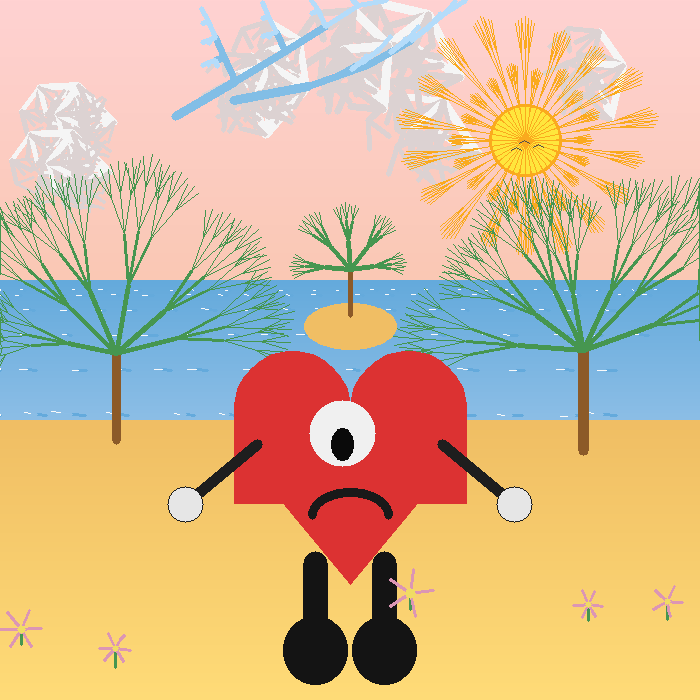

In [12]:
final_landscape_image = create_bad_bunny_scape()
print("Paisaje final generado.")
cv2_imshow(final_landscape_image)